<a href="https://colab.research.google.com/github/Rio-HEPLab/ML4Physics/blob/PPGF-2025-1/10-Classifica%C3%A7%C3%A3o_D%C3%ADgitos_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Redes neurais

Unidade – perceptron com função de ativação $f$:

<figure>
<img src="https://raw.githubusercontent.com/Rio-HEPLab/ML4Physics/PPGF-2025-1/pics/NN-Neuron.png" align='center' width="500" height="300">
</figure>

<br>

Rede neural totalmente conectada (*feed forward*):

<figure>
<img src="https://raw.githubusercontent.com/Rio-HEPLab/ML4Physics/PPGF-2025-1/pics/NN-Feed-Forward.png" align='center' width="650" height="300">
</figure>

Saída $j$ da camada $l$ ($x_{j}^{l}$):

$ x_{j}^{l} = f( s_{j}^{l} ) \; ; \; s_{j}^{l} = \sum_{i=0}^{d^{(l-1)}} w_{ij}^{l} x_{i}^{l-1} $

Função erro (minimização SGD):

$ \textbf{E}( h( \mathbf{x}_n), y_n ) \equiv \textbf{E}(\textbf{w}) $

Gradientes:

$ \nabla_{\textbf{w}} \textbf{E}(\textbf{w}) = \frac{ \partial \textbf{E}(\textbf{w}) }{ \partial w_{ij}^{l} } = \sum_{k} \frac{ \partial \textbf{E}(\textbf{w}) }{ \partial s_{k}^{l} } \frac{ \partial s_{k}^{l} }{ \partial w_{ij}^{l} } = \frac{ \partial \textbf{E}(\textbf{w}) }{ \partial s_{j}^{l} } \frac{ \partial s_{j}^{l} }{ \partial w_{ij}^{l} } = \delta_{j}^{l} x_{i}^{l-1} $ ,

onde $ \delta_{j}^{l} = \frac{ \partial \textbf{E}(\textbf{w}) }{ \partial s_{j}^{l} } $

Última camada ($l = L$):

$ x_{1}^{L} = f( s_{1}^{L} ) $

$ \delta_{1}^{L} = \frac{ \partial \textbf{E}(\textbf{w}) }{ \partial s_{1}^{L} } \rightarrow \delta_{1}^{L} \propto f^{'}( s_{1}^{L} ) $

"Propagação reversa" (*Backpropagation*):

$ \delta_{i}^{l-1} = \frac{ \partial \textbf{E}(\textbf{w}) }{ \partial s_{i}^{l-1} } = \sum_{j=0}^{d^{(l)}} \frac{ \partial \textbf{E}(\textbf{w}) }{ \partial s_{j}^{l} } \frac{ \partial s_{j}^{l} }{ \partial s_{i}^{l-1} } $

$ \frac{ \partial s_{j}^{l} }{ \partial s_{i}^{l-1} } = \sum_{k} \frac{ \partial s_{j}^{l} }{ \partial x_{k}^{l-1} } \frac{ \partial x_{k}^{l-1} }{ \partial s_{i}^{l-1} } = \frac{ \partial s_{j}^{l} }{ \partial x_{i}^{l-1} } \frac{ \partial x_{i}^{l-1} }{ \partial s_{i}^{l-1} } = w_{ij}^{l} \, f^{'}( s_{i}^{l-1} ) $

$ \delta_{i}^{l-1} = \sum_{j=0}^{d^{(l)}} \; \delta_{j}^{l} \; w_{ij}^{l} \; f^{'}( s_{i}^{l-1} ) $

Atualização dos pesos:

$ {w_{ij}^{l}} \rightarrow {w_{ij}^{l}}^{'} = {w_{ij}^{l}} - \eta \, \delta_{j}^{l} \, x_{i}^{l-1} $


In [ ]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import joblib
from joblib import dump, load

import sklearn
import tensorflow as tf
from tensorflow import keras

print ( "sklearn: {}".format(sklearn.__version__) )
print ( "tensorflow: {}".format(tf.__version__) )

sklearn: 1.6.1
tensorflow: 2.18.0


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

print ( gpus )

[]


In [ ]:
train_model = True
run_grid_search = True
save_model = True

model_path = "keras_model.keras"
scaler_path = "standard_scaler.joblib"

### Amostra de dígitos

In [ ]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:50000])]))[:, 1]
    reorder_valid = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[50000:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:50000] = mnist.data[reorder_train]
    mnist.target[:50000] = mnist.target[reorder_train]
    mnist.data[50000:60000] = mnist.data[reorder_valid + 50000]
    mnist.target[50000:60000] = mnist.target[reorder_valid + 50000]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)
X_train_raw = mnist.data[:50000]
y_train = mnist.target[:50000]
X_valid_raw = mnist.data[50000:60000]
y_valid = mnist.target[50000:60000]
X_test_raw = mnist.data[60000:]
y_test = mnist.target[60000:]

print ( X_train_raw.shape )
print ( X_valid_raw.shape )
print ( X_test_raw.shape )

(50000, 784)
(10000, 784)
(10000, 784)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = None
X_train = None
if train_model:
    scaler = StandardScaler()
    X_train = scaler.fit_transform( X_train_raw )
else:
    scaler = load( scaler_path )
    X_train = scaler.transform( X_train_raw )
X_valid = scaler.transform( X_valid_raw )
X_test  = scaler.transform( X_test_raw )

print ( scaler )

if train_model and save_model:
    dump( scaler, scaler_path )

StandardScaler()


9
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.00483977 -0.00630411 -0.00447218 -0.00447218  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -0.00447218 -0.00515922 -0.00963928 -0.01211949
 -0.01436819 -0.01737385 -0.02270852 -0.02757692 -0.02980096 -0.03081968
 -0.03110097 -0.03015775 -0.03021858 -0.02670023 -0.02103146 -0.01838468
 -0.0166327  -0.01131016 -0.00800445 -0.00479882  0.          0.
  0.          0.          0.          0.         -0.00447218 -0.00447218
 -0.00889745 -0.01236598 -0.01790015 -0.02738895 -0.0371536  -0.05175937
 -0.06602942 -0.082747   -0.10052937 -0.11606085 -0.12843945 -0.13638324
 -0.13592586 -0.1297393  -0.11885722 -0.10081914 -0.07808218 -0.05640676
 -0.03917999 -0.02442581 -0.01543332 -0.00857831  0.          0.
  0.          0.         -0.0048

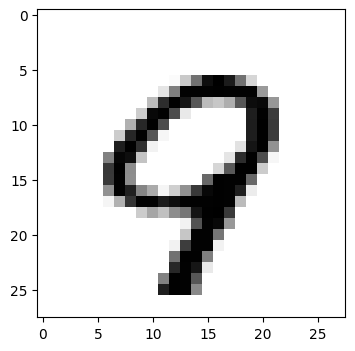

In [ ]:
idx = 9900
print ( y_valid[ idx ] )
print ( X_valid[ idx ] )

fig = plt.figure( figsize=(4,4) )
plt.imshow( X_valid_raw[ idx ].reshape(28,28), cmap='binary' )

### Treinamento

In [ ]:
shuffle_index = np.random.permutation( 50000 )
X_train_shuffle, y_train_shuffle = X_train[ shuffle_index ], y_train[ shuffle_index ]
print ( X_train_shuffle )
print ( y_train_shuffle )

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[3 2 5 ... 2 7 9]


### Definição do modelo

Com regularização por *Dropout*

Hyperparâmetros do modelo: Número de camadas internas, número de células por camada (assumindo iguais para todas as camadas)

Hyperparâmetros do treinamento: Fração de dropout, tamanho do *batch* (mais à frente)

In [ ]:
class HyperModel:
    def __init__(self, input_shape, learning_rate):
        self.input_shape = input_shape
        self.learning_rate = learning_rate

    def build(self, n_hidden, n_neurons, dropout):
        input_shape = self.input_shape
        learning_rate = self.learning_rate

        print( "Building model with:" )
        print( "Input shape: {}".format(input_shape) )
        print( "Learning rate: {}".format(learning_rate) )
        print( "Number of hidden layers: {}".format(n_hidden) )
        print( "Number of neurons per layer: {}".format(n_neurons) )
        print( "Dropout rate: {}".format(dropout) )

        model = keras.models.Sequential()
        model.add( keras.layers.InputLayer(input_shape=input_shape) )
        for layer in range(n_hidden):
            if dropout > 0.:
                model.add( keras.layers.Dropout(rate=dropout) )
            model.add( keras.layers.Dense(n_neurons, activation="elu", kernel_initializer="he_normal") )
        if dropout > 0.:
            model.add( keras.layers.Dropout(rate=dropout) )
        model.add( keras.layers.Dense(10, activation="softmax") )

        #optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
        optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
        model.compile( loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

        return model

def build_model(input_shape, learning_rate=5e-4, n_hidden=1, n_neurons=50, dropout=0.20 ):
    hypermodel_ = HyperModel( input_shape=input_shape, learning_rate=learning_rate )
    return hypermodel_.build( n_hidden, n_neurons, dropout )


### Callbacks

In [ ]:
import os

def get_run_logdir(log_dir):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(log_dir, run_id)

def callbacks(patience=5, lr_scheduler_fn=None, log_dir=None):
    callbacks_ = []
    # Early stopping
    if patience > 0:
        early_stopping_cb_ = keras.callbacks.EarlyStopping( patience=patience, restore_best_weights=True )
        callbacks_.append( early_stopping_cb_ )

    # Learning rate exponential decay
    if lr_scheduler_fn:
        lr_scheduler_cb_ = keras.callbacks.LearningRateScheduler( lr_scheduler_fn )
        callbacks_.append( lr_scheduler_cb_ )

    # TensorBoard
    if log_dir:
        run_logdir = get_run_logdir(log_dir)
        print ( "Log dir: {}".format(run_logdir) )
        tensorboard_cb_ = keras.callbacks.TensorBoard( run_logdir )
        callbacks_.append( tensorboard_cb_ )

    return callbacks_


In [ ]:
model = build_model(
    input_shape=X_train_shuffle.shape[1:],
    learning_rate=5e-4,
    n_hidden=2,
    n_neurons=20,
    dropout=0.10
    )
model.summary()

Building model with:
Input shape: (784,)
Learning rate: 0.0005
Number of hidden layers: 2
Number of neurons per layer: 20
Dropout rate: 0.1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │        15,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,330 (63.79 KB)

 Trainable params: 16,330 (63.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks_ = callbacks( patience=3 )
epochs_ = 20
batch_size_ = 32
history = model.fit( X_train_shuffle, y_train_shuffle, epochs=epochs_, batch_size=batch_size_, validation_data=(X_valid, y_valid), callbacks=callbacks_ )

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.6942 - loss: 1.0170 - val_accuracy: 0.9201 - val_loss: 0.2933
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8772 - loss: 0.4222 - val_accuracy: 0.9335 - val_loss: 0.2732
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8954 - loss: 0.3574 - val_accuracy: 0.9366 - val_loss: 0.2735
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9018 - loss: 0.3249 - val_accuracy: 0.9424 - val_loss: 0.2488
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9096 - loss: 0.2962 - val_accuracy: 0.9464 - val_loss: 0.2214
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9154 - loss: 0.2743 - val_accuracy: 0.9508 - val_loss: 0.2001
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9171 - loss: 0.2699 - val_accuracy: 0.9503 - val_loss: 0.1910
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9195 - loss: 0.2555 -

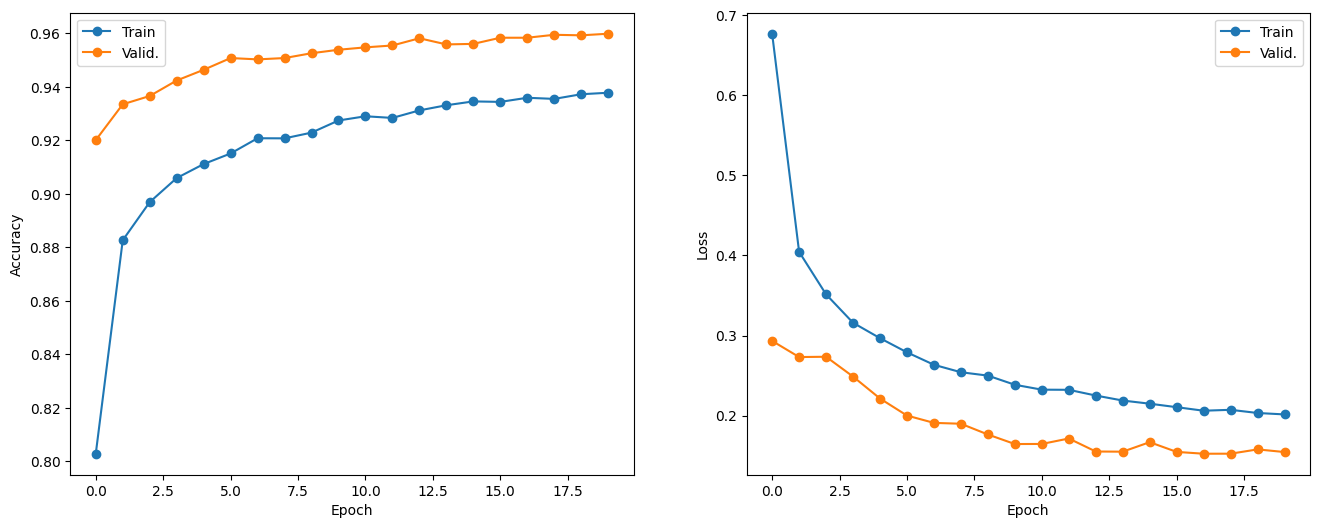

In [ ]:
fig, axes = plt.subplots( 1, 2, figsize=(16,6) )
axes[0].plot( history.epoch, history.history['accuracy'], 'o-', label="Train" )
axes[0].plot( history.epoch, history.history['val_accuracy'], 'o-', label="Valid." )
axes[1].plot( history.epoch, history.history['loss'], 'o-', label="Train" )
axes[1].plot( history.epoch, history.history['val_loss'], 'o-', label="Valid." )
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend( loc='best' )
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend( loc='best' )

In [ ]:
model.evaluate( X_train, y_train ) # without dropout

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9756 - loss: 0.0848


[0.10920975357294083, 0.9669399857521057]

In [ ]:
model.evaluate( X_valid, y_valid )

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9677 - loss: 0.1283


[0.152457594871521, 0.9584000110626221]

### Learning rate scan

In [ ]:
def find_max_learning_rate( X, y, X_val, y_val, lr_init=1e-4, lr_end=5e-2, steps=20, epochs=20, model_build_fn=build_model, callback_fn=callbacks, *build_fn_args, **build_fn_kwargs ):
    results_ = {}
    results_['learning_rate'] = []
    results_['loss'] = []
    results_['accuracy'] = []
    results_['val_loss'] = []
    results_['val_accuracy'] = []
    c_ = (lr_end/lr_init) ** (1/steps)
    lr_ = lr_init
    for i_it in range( steps + 1 ):
        results_['learning_rate'].append( lr_ )
        model_ = model_build_fn( *build_fn_args, **build_fn_kwargs, learning_rate=lr_ )
        callbacks_ = callback_fn(patience=3)
        history_ = model_.fit( X, y, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks_ )
        results_['loss'].append( history_.history['loss'] )
        results_['accuracy'].append( history_.history['accuracy'] )
        results_['val_loss'].append( history_.history['val_loss'] )
        results_['val_accuracy'].append( history_.history['val_accuracy'] )
        # Update learning rate
        lr_ = lr_ * c_

    return results_

In [ ]:
learning_rate_scan = True
epochs_lr_scan = 20
results = None
if learning_rate_scan:
    results = find_max_learning_rate(
                X_train_shuffle, y_train_shuffle,
                X_valid, y_valid,
                lr_init=1e-4,
                lr_end=2e-2,
                steps=5,
                epochs=epochs_lr_scan,
                model_build_fn=build_model,
                input_shape=X_train_shuffle.shape[1:],
                n_hidden=2,
                n_neurons=20,
                dropout=0.,
                )

Building model with:
Input shape: (784,)
Learning rate: 0.0001
Number of hidden layers: 2
Number of neurons per layer: 20
Dropout rate: 0.0
Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5031 - loss: 1.6193 - val_accuracy: 0.8706 - val_loss: 0.5099
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8710 - loss: 0.4790 - val_accuracy: 0.9068 - val_loss: 0.3496
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9028 - loss: 0.3476 - val_accuracy: 0.9226 - val_loss: 0.2944
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9175 - loss: 0.2867 - val_accuracy: 0.9299 - val_loss: 0.2653
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9253 - loss: 0.2578 - val_accuracy: 0.9348 - val_loss: 0.2458
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9315 - loss: 0.2291 - val_accuracy: 0.9385 - val_loss: 0.2337
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9375 - loss:

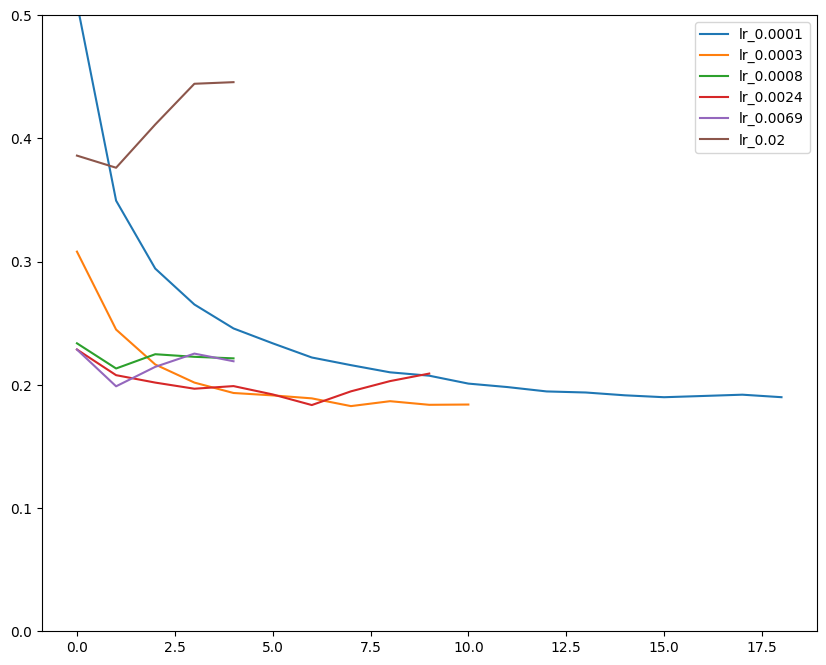

In [ ]:
if learning_rate_scan:
    # metrics_ = 'loss'
    metrics_ = 'val_loss'
    # metrics_ = 'val_accuracy'
    columns_=["lr_{}".format(lr_) for lr_ in np.round( results['learning_rate'], 4)]
    df_ = pd.DataFrame( np.full((epochs_lr_scan,len(columns_)),np.nan), columns=columns_ )
    fig_ = plt.figure( figsize=(10,8) )
    for i_lr_,col_ in enumerate(columns_):
        df_[col_] = pd.Series( results[ metrics_ ][i_lr_] )
        df_[col_].plot()
    plt.legend()
    # plt.yscale('log')
    plt.ylim( 0., 0.50 )
    # plt.ylim( 0.80, 1.05 )

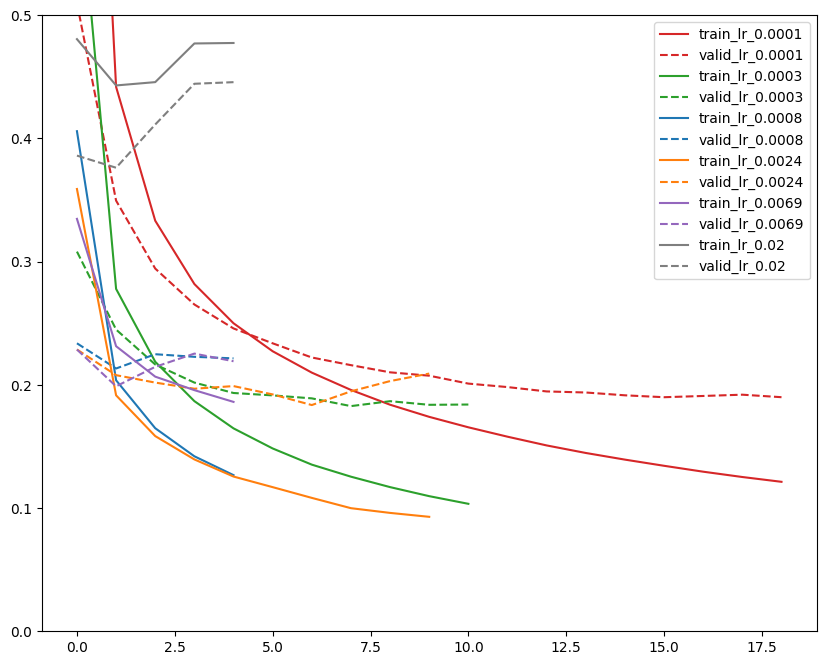

In [ ]:
if learning_rate_scan:
    metrics_train_ = 'loss'
    metrics_valid_ = 'val_loss'
    colors_=['tab:red','tab:green','tab:blue','tab:orange', 'tab:purple', 'tab:gray']
    columns_=["lr_{}".format(lr_) for lr_ in np.round( results['learning_rate'], 4)]
    df_ = pd.DataFrame( np.full((epochs_lr_scan,2*len(columns_)),np.nan), columns=( 2 * columns_ ) )
    fig_ = plt.figure( figsize=(10,8) )
    for i_lr_,col_ in enumerate(columns_):
        df_[ "train_{}".format( col_ ) ] = pd.Series( results[ metrics_train_ ][i_lr_] )
        df_[ "train_{}".format( col_ ) ].plot( color=colors_[ i_lr_ % len(colors_) ] )
        df_[ "valid_{}".format( col_ ) ] = pd.Series( results[ metrics_valid_ ][i_lr_] )
        df_[ "valid_{}".format( col_ ) ].plot( color=colors_[ i_lr_ % len(colors_) ], linestyle='dashed' )
    plt.legend()
    # plt.yscale('log')
    plt.ylim( 0., 0.50 )

#### Exponential learning rate scheduling

In [ ]:
class ExponentialDecayLR:
    def __init__( self, lr0, s ):
        self.lr0 = lr0
        self.s = s
    def __call__( self, epoch ):
        return self.lr0 * 0.1**( epoch / self.s )

(1e-05, 0.02)

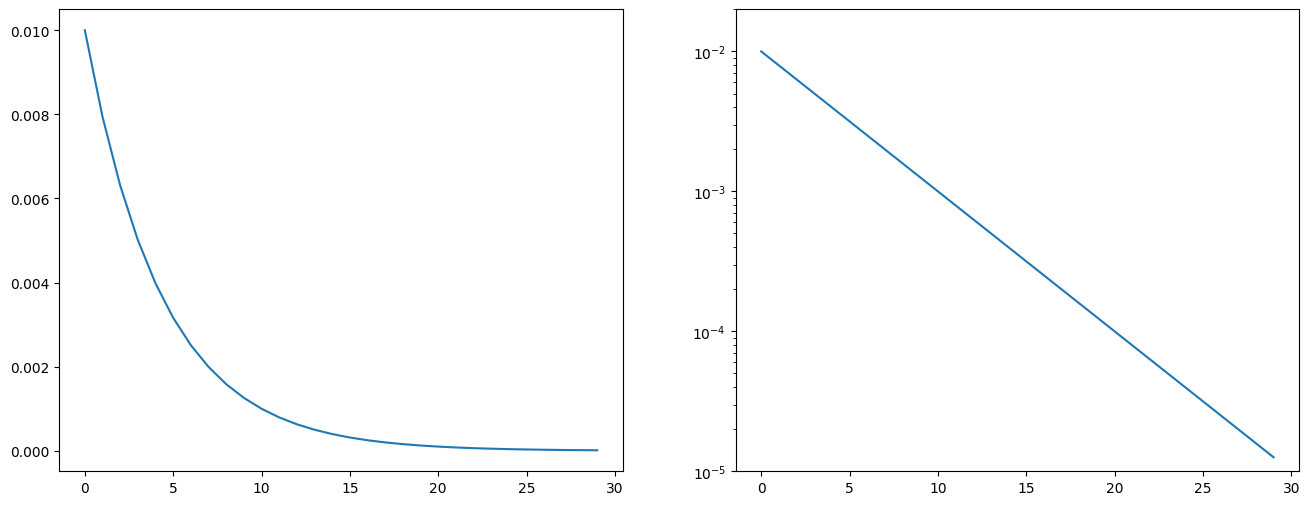

In [ ]:
exponential_decay_ = ExponentialDecayLR( lr0=1e-2, s=10 )

fig, axes = plt.subplots( 1, 2, figsize=(16,6) )
xplot__ = np.arange(30)
axes[0].plot( xplot__, exponential_decay_( xplot__ ) )
axes[1].plot( xplot__, exponential_decay_( xplot__ ) )
axes[1].set_yscale( 'log' )
axes[1].set_ylim( 1e-5, 2e-2 )

In [ ]:
model = build_model(
    input_shape=X_train_shuffle.shape[1:],
    learning_rate=1e-2,
    n_hidden=2,
    n_neurons=20,
    dropout=0.10
    )

callbacks_ = callbacks( patience=3, lr_scheduler_fn=exponential_decay_ )
epochs_ = 20
batch_size_ = 32
history = model.fit( X_train_shuffle, y_train_shuffle, epochs=epochs_, batch_size=batch_size_, validation_data=(X_valid, y_valid), callbacks=callbacks_ )

Building model with:
Input shape: (784,)
Learning rate: 0.01
Number of hidden layers: 2
Number of neurons per layer: 20
Dropout rate: 0.1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8130 - loss: 0.6629 - val_accuracy: 0.9120 - val_loss: 0.2879 - learning_rate: 0.0100
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8855 - loss: 0.3933 - val_accuracy: 0.9282 - val_loss: 0.2522 - learning_rate: 0.0079
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8944 - loss: 0.3693 - val_accuracy: 0.9292 - val_loss: 0.2205 - learning_rate: 0.0063
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9107 - loss: 0.3195 - val_accuracy: 0.9422 - val_loss: 0.1967 - learning_rate: 0.0050
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9180 - loss: 0.2875 - val_accuracy: 0.9473 - val_loss: 0.1767 - learning_rate: 0.0040
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9208 - loss: 0.2717 - val_accuracy: 0.9533 - val_loss: 0.1648 - learning_rate: 0.0032
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9253 

In [ ]:
history.history

{'accuracy': [0.8507199883460999,
  0.8872399926185608,
  0.8970999717712402,
  0.9087799787521362,
  0.9162600040435791,
  0.9205999970436096,
  0.9248600006103516,
  0.9280800223350525,
  0.9302999973297119,
  0.9330199956893921,
  0.9356200098991394,
  0.9382799863815308,
  0.9376400113105774,
  0.9401400089263916,
  0.9405199885368347,
  0.9407399892807007,
  0.9417399764060974,
  0.9414799809455872,
  0.9420400261878967,
  0.9421200156211853],
 'loss': [0.5224548578262329,
  0.3924177587032318,
  0.3558398485183716,
  0.3227957785129547,
  0.2916821241378784,
  0.27097436785697937,
  0.25907808542251587,
  0.24367813766002655,
  0.2354314774274826,
  0.22474628686904907,
  0.21294113993644714,
  0.20702959597110748,
  0.20971471071243286,
  0.19904299080371857,
  0.20117174088954926,
  0.1959563046693802,
  0.19289234280586243,
  0.1971016675233841,
  0.19275139272212982,
  0.18876007199287415],
 'val_accuracy': [0.9120000004768372,
  0.9282000064849854,
  0.9291999936103821,
  0.

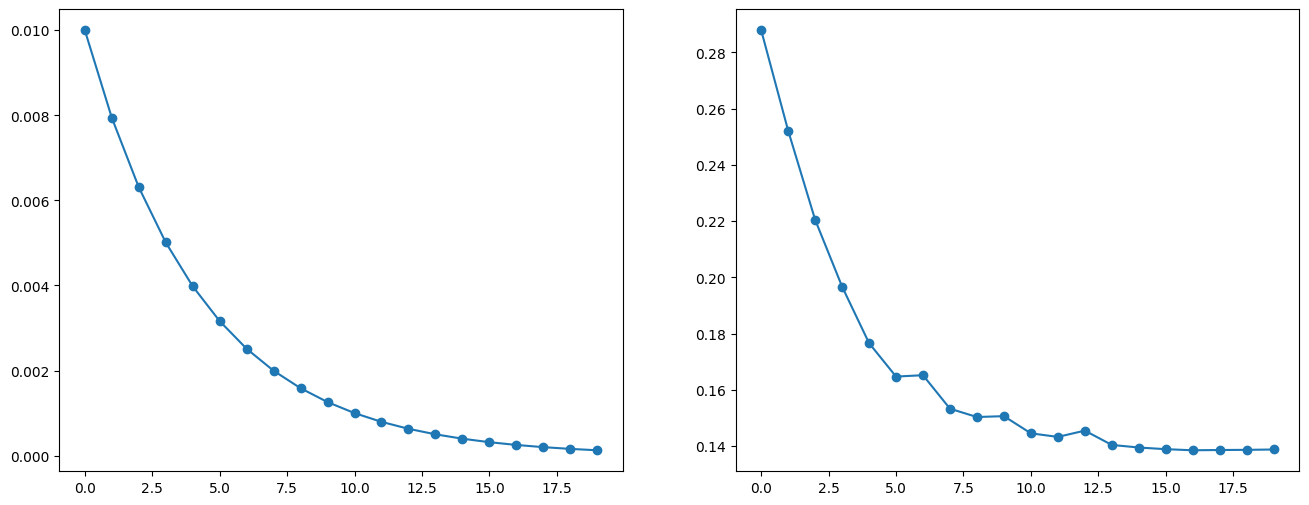

In [ ]:
fig, axes = plt.subplots( 1, 2, figsize=(16,6) )
axes[0].plot( history.epoch, history.history['learning_rate'], 'o-' )
axes[1].plot( history.epoch, history.history['val_loss'], 'o-' )

### Hyperparameter scan

In [ ]:
# !pip install scikeras
# import scikeras
# import scikeras.wrappers

In [ ]:
# cv = 4
# n_jobs = 8
# n_iter_search = 10
# epochs_grid_search = 5
# # scoring = 'accuracy'
# # scoring = 'f1'

# grid_search = None
# if train_model and run_grid_search:
#     import time
#     print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
#     time_s_ = time.time()

#     callbacks_ = callbacks( patience=5, lr_scheduler_fn=exponential_decay_ )
#     print ( callbacks_ )

#     from sklearn.model_selection import RandomizedSearchCV
#     def model_fn_( n_hidden, n_neurons, dropout ):
#         build_fn_ = Model( input_shape=X_train_shuffle.shape[1:], learning_rate=1e-2 )
#         return build_fn_( n_hidden, n_neurons, dropout )
#     params_ = {'n_hidden': 2, 'n_neurons': 50, 'dropout': 0.20, 'batch_size': 32}
#     keras_clf = scikeras.wrappers.KerasClassifier( model=model_fn_, **params_, callbacks=callbacks_ )
#     print ( keras_clf )
#     param_distribs = {
#         "n_hidden": np.arange(2,6),
#         "n_neurons": 2 ** np.arange(4,8),
#         "dropout":  0.1 * np.arange(2,6),
#         "batch_size": 2 ** np.arange(5,8)
#         }
#     grid_search = RandomizedSearchCV(
#         keras_clf,
#         param_distribs,
#         n_iter=n_iter_search, cv=cv, verbose=20, n_jobs=n_jobs, refit=False, random_state=42
#         )
#     with joblib.parallel_backend( "threading" ):
#         grid_search.fit( X_train_shuffle, y_train_shuffle, epochs=epochs_grid_search, validation_data=(X_valid, y_valid) )
#     print ( grid_search.best_params_ )
#     print ( grid_search.best_score_ )
#     print ( grid_search.cv_results_ )

#     time_e_ = time.time()
#     print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

class HyperModel(kt.HyperModel):
    def __init__(self, input_shape, learning_rate):
        self.input_shape = input_shape
        self.learning_rate = learning_rate

    def build(self, hp):
        n_hidden = hp.Int( "n_hidden", min_value=1, max_value=6 )
        n_neurons = hp.Choice( "n_neurons", ( 2 ** np.arange(4,8) ).tolist() )
        dropout = hp.Choice("dropout", ( 0.1 * np.arange(1,6) ).tolist() )

        print( "Building model with:" )
        print( "Input shape: {}".format(self.input_shape) )
        print( "Learning rate: {}".format(self.learning_rate) )
        print( "Number of hidden layers: {}".format(n_hidden) )
        print( "Number of neurons per layer: {}".format(n_neurons) )
        print( "Dropout rate: {}".format(dropout) )

        model = keras.models.Sequential()
        model.add( keras.layers.InputLayer(input_shape=self.input_shape) )
        for layer in range(n_hidden):
            if dropout > 0.:
                model.add( keras.layers.Dropout(rate=dropout) )
            model.add( keras.layers.Dense(n_neurons, activation="elu", kernel_initializer="he_normal") )
        if dropout > 0.:
            model.add( keras.layers.Dropout(rate=dropout) )
        model.add( keras.layers.Dense(10, activation="softmax") )

        #optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
        optimizer = keras.optimizers.Nadam(learning_rate=self.learning_rate)
        model.compile( loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

        return model

    def fit(self, hp, model, *args, **kwargs):
        batch_size_ = hp.Choice( "batch_size", ( 2 ** np.arange(5,8) ).tolist() )
        print( "Batch size: {}".format( batch_size_ ) )
        return model.fit(
            *args,
            batch_size=batch_size_,
            **kwargs,
        )


In [ ]:
epochs_ = 20

n_hidden_ = 2
n_neurons_ = 20
dropout_ = 0.20
batch_size_ = 32

hp = kt.HyperParameters()
hp.values = { "n_hidden": n_hidden_, "n_neurons": n_neurons_, "dropout": dropout_, "batch_size": batch_size_ }
print ( hp.values )

hypermodel = HyperModel( input_shape=X_train_shuffle.shape[1:], learning_rate=1e-2 )
model = hypermodel.build(hp)
callbacks_ = callbacks( patience=3, lr_scheduler_fn=exponential_decay_ )

hypermodel.fit(hp, model, X_train_shuffle, y_train_shuffle, epochs=epochs_, validation_data=(X_valid, y_valid), callbacks=callbacks_ )

{'n_hidden': 2, 'n_neurons': 20, 'dropout': 0.2, 'batch_size': 32}
Building model with:
Input shape: (784,)
Learning rate: 0.01
Number of hidden layers: 2
Number of neurons per layer: 20
Dropout rate: 0.2
Batch size: 32
Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.7522 - loss: 0.8463 - val_accuracy: 0.9019 - val_loss: 0.3348 - learning_rate: 0.0100
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8402 - loss: 0.5535 - val_accuracy: 0.9247 - val_loss: 0.2612 - learning_rate: 0.0079
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8549 - loss: 0.5090 - val_accuracy: 0.9272 - val_loss: 0.2423 - learning_rate: 0.0063
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8655 - loss: 0.4583 - val_accuracy: 0.9317 - val_loss: 0.2368 - learning_rate: 0.0050
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8787 - loss: 0.4307 - val_accuracy: 0.9408 - val_loss: 0.2112 - learning_rate: 0.0040
Epoch 6

In [ ]:
n_iter_search = 5
epochs_grid_search = 10

grid_search = None
if train_model and run_grid_search:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    callbacks_ = callbacks( patience=3, lr_scheduler_fn=exponential_decay_ )
    print ( callbacks_ )

    tuner = kt.RandomSearch(
        HyperModel( input_shape=X_train_shuffle.shape[1:], learning_rate=1e-2 ),
        objective="val_accuracy",
        max_trials=n_iter_search,
        executions_per_trial=3,
        overwrite=True,
        directory="tuner",
        project_name="ann_hypermodel"
    )
    print ( tuner.search_space_summary() )

    tuner.search( X_train_shuffle, y_train_shuffle, epochs=epochs_grid_search, validation_data=(X_valid, y_valid), callbacks=callbacks_ )

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

Trial 5 Complete [00h 04m 23s]
val_accuracy: 0.9492666522661845

Best val_accuracy So Far: 0.9743333260218302
Total elapsed time: 00h 20m 40s
Total time elapsed: 1240


### Ajuste do modelo com parâmetros otimizados

In [ ]:
hp = tuner.get_best_hyperparameters()[0]
hp.values

{'n_hidden': 4, 'n_neurons': 64, 'dropout': 0.1, 'batch_size': 64}

In [ ]:
model_final = None
history = None

if train_model:
    hp = None
    params = None
    if run_grid_search:
        hp = tuner.get_best_hyperparameters()[0]
        params = hp.values
    else:
        params = { 'n_hidden': 2, 'n_neurons': 50, 'dropout': 0.20, 'batch_size': 32 }
        hp = kt.HyperParameters()
        hp.values = params
    print ( params )

    hypermodel = HyperModel( input_shape=X_train_shuffle.shape[1:], learning_rate=1e-2 )
    model_final = hypermodel.build( hp )

    log_dir="keras_logs"
    callbacks_ = callbacks(patience=3, lr_scheduler_fn=exponential_decay_, log_dir=log_dir)
    print ( callbacks_ )

    epochs_ = 50
    history = hypermodel.fit(hp, model_final, X_train_shuffle, y_train_shuffle, epochs=epochs_, validation_data=(X_valid, y_valid), callbacks=callbacks_ )

    if save_model:
        model_final.save( model_path )
else:
    model_final = keras.models.load_model( model_path )

{'n_hidden': 4, 'n_neurons': 64, 'dropout': 0.1, 'batch_size': 64}
Building model with:
Input shape: (784,)
Learning rate: 0.01
Number of hidden layers: 4
Number of neurons per layer: 64
Dropout rate: 0.1
Log dir: keras_logs/run_2025_05_05-03_49_26
[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7b0bb5a1f110>, <keras.src.callbacks.learning_rate_scheduler.LearningRateScheduler object at 0x7b0bb7b6c390>, <keras.src.callbacks.tensorboard.TensorBoard object at 0x7b0bb7aa7050>]
Batch size: 64
Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8163 - loss: 0.6796 - val_accuracy: 0.9289 - val_loss: 0.2758 - learning_rate: 0.0100
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9107 - loss: 0.3341 - val_accuracy: 0.9467 - val_loss: 0.1983 - learning_rate: 0.0079
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9280 - loss: 0.2740 - val_accuracy: 0.9501 - val_loss: 0.2000 - learning_rate: 0.0063
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━

In [ ]:
model_final.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_7 (Dropout)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,113 (742.63 KB)

 Trainable params: 63,370 (247.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 126,743 (495.09 KB)

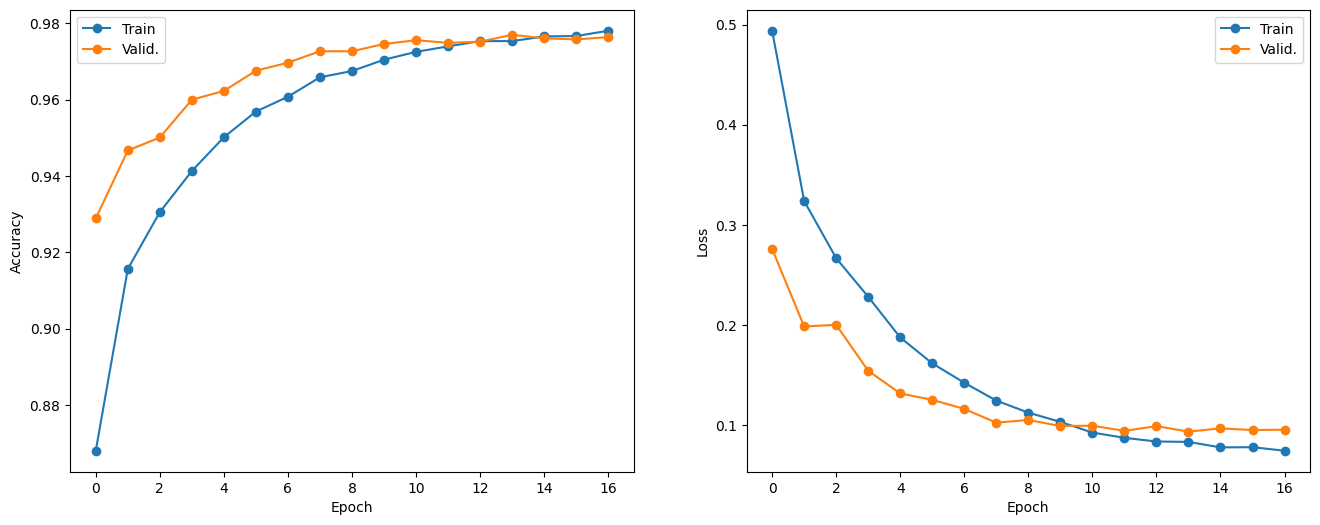

In [ ]:
if history is not None:
    fig, axes = plt.subplots( 1, 2, figsize=(16,6) )
    axes[0].plot( history.epoch, history.history['accuracy'], 'o-', label="Train" )
    axes[0].plot( history.epoch, history.history['val_accuracy'], 'o-', label="Valid." )
    axes[1].plot( history.epoch, history.history['loss'], 'o-', label="Train" )
    axes[1].plot( history.epoch, history.history['val_loss'], 'o-', label="Valid." )
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend( loc='best' )
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend( loc='best' )

In [ ]:
model_final.evaluate( X_train, y_train ) # without dropout

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9929 - loss: 0.0235


[0.029929736629128456, 0.9907600283622742]

In [ ]:
model_final.evaluate( X_valid, y_valid )

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9826 - loss: 0.0754


[0.0932421088218689, 0.9769999980926514]

### Teste

In [ ]:
model_final.evaluate( X_test, y_test )

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9806 - loss: 0.0766


[0.10358452051877975, 0.9747999906539917]

In [ ]:
y_test_proba = model_final.predict( X_test )
print ( y_test_proba )
y_test_pred = np.argmax( y_test_proba, axis=-1 )
print ( y_test_pred )

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[9.9999768e-01 8.3098465e-14 6.7580828e-08 ... 1.4583272e-08
  1.8621684e-08 2.5121190e-08]
 [9.9999565e-01 4.0883987e-14 9.9730505e-07 ... 6.4957848e-09
  1.4127214e-07 2.8871600e-08]
 [9.9999982e-01 2.1198835e-16 9.0618215e-09 ... 5.3745605e-11
  3.0422678e-09 2.8754252e-10]
 ...
 [1.4976295e-07 7.1057730e-07 1.7131504e-06 ... 2.8940022e-04
  5.8042275e-05 9.9903566e-01]
 [5.8225251e-09 2.2628955e-08 1.1886296e-07 ... 4.7998863e-05
  5.6536878e-06 9.9988252e-01]
 [1.2330742e-09 3.6156518e-09 3.3095230e-08 ... 1.6298483e-05
  1.7143221e-06 9.9994689e-01]]
[0 0 0 ... 9 9 9]


In [ ]:
accuracy = np.sum( y_test_pred == y_test ) / y_test.size
print ( "Accuracy = {}".format( accuracy ) )

Accuracy = 0.9748


252
0: 12
1: 14
2: 26
3: 22
4: 33
5: 28
6: 23
7: 27
8: 34
9: 33


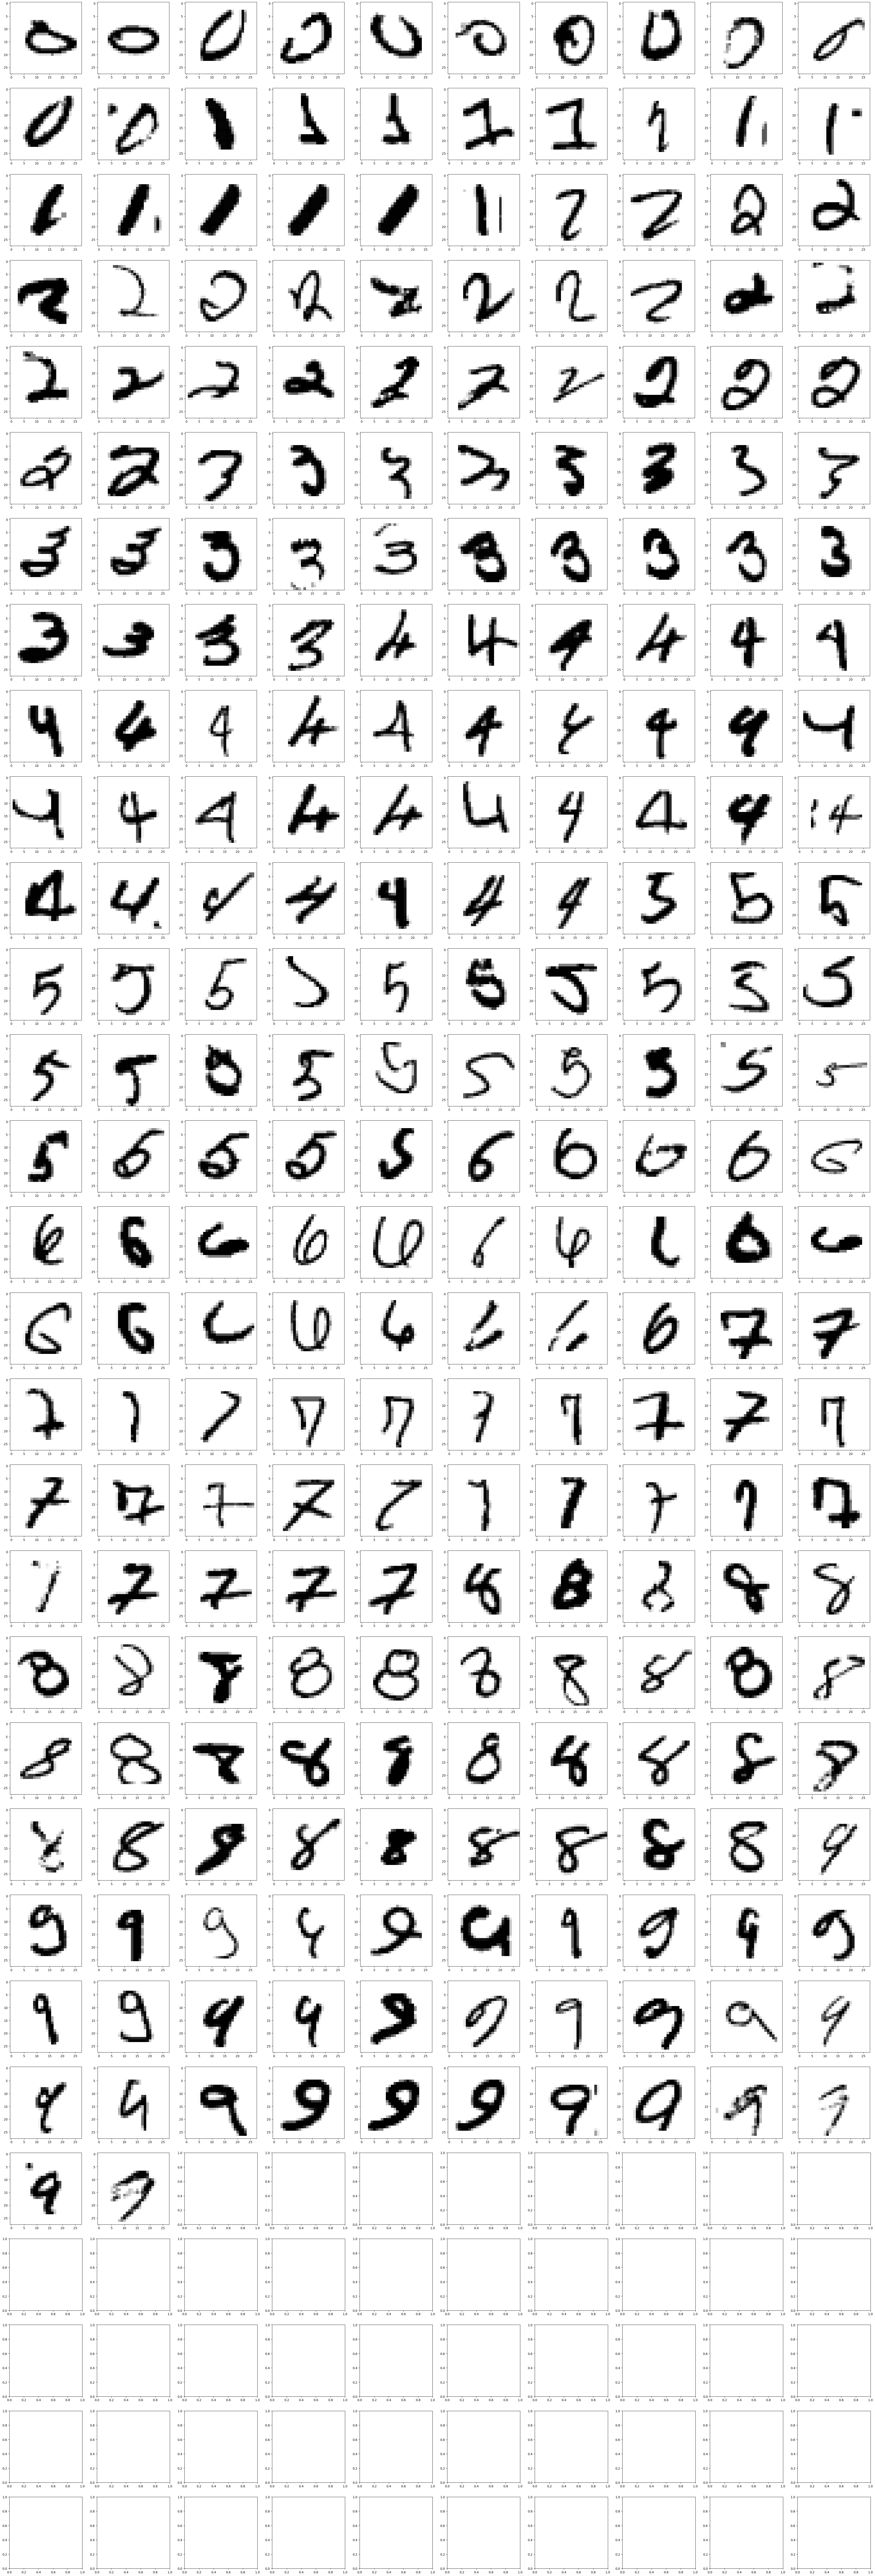

In [ ]:
def plot_digits( X, n, start = 0 ):
    n_per_row_ = 10
    n_rows_ = int( ( n / n_per_row_  ) if ( n % n_per_row_ ) == 0 else ( ( n // n_per_row_ ) + 1 ) )
    size_ = 5
    fig_, axes_ = plt.subplots( n_rows_, n_per_row_, figsize=( n_per_row_ * size_ , n_rows_ * size_ ) )
    idx_row_, idx_col_ = 0, 0
    for idx__ in range( n ):
        if idx__ >= len( X ): break

        ax_ = axes_[ idx_row_, idx_col_ ]
        ax_.imshow( X[ start+idx__ ].reshape(28,28), cmap='binary' )
        idx_col_ += 1
        if idx_col_ % n_per_row_ == 0:
            idx_row_ += 1
            idx_col_  = 0

msk_error_ = y_test_pred != y_test
print ( np.sum( msk_error_ ) )
for label_ in range( 10 ):
    msk__ = msk_error_ & ( y_test == label_ )
    print ( "{}: {}".format( label_, np.sum( msk__ ) ) )

plot_digits( X_test_raw[ msk_error_ ], 300 )